<a href="https://colab.research.google.com/github/vivekbiragoni/Deep_Learning/blob/main/pytorch/Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install datasets

In [45]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm

In [46]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [47]:
train_data, test_data = datasets.load_dataset("imdb", split=["train", "test"])

In [48]:
train_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 25000
 }))

In [49]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

In [50]:
def tokenize_example(example, tokenizer, max_length):
    tokens = tokenizer(example["text"])[:max_length]
    return {"tokens": tokens}

In [51]:
max_length = 256

train_data = train_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)
test_data = test_data.map(
    tokenize_example, fn_kwargs={"tokenizer": tokenizer, "max_length": max_length}
)

In [52]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data["train"]
valid_data = train_valid_data["test"]

In [53]:
min_freq = 5
special_tokens = ["<unk>", "<pad>"]

vocab = torchtext.vocab.build_vocab_from_iterator(
    train_data["tokens"],
    min_freq=min_freq,
    specials=special_tokens,
)

In [54]:
unk_index = vocab["<unk>"]
pad_index = vocab["<pad>"]

In [55]:
vocab.set_default_index(unk_index)

In [56]:
def numericalize_example(example, vocab):
    ids = vocab.lookup_indices(example["tokens"])
    return {"ids": ids}

In [57]:
train_data = train_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
valid_data = valid_data.map(numericalize_example, fn_kwargs={"vocab": vocab})
test_data = test_data.map(numericalize_example, fn_kwargs={"vocab": vocab})

In [58]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [59]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [60]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [61]:
batch_size = 512

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [62]:
class CNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        n_filters,
        filter_sizes,
        output_dim,
        dropout_rate,
        pad_index,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.convs = nn.ModuleList(
            [
                nn.Conv1d(embedding_dim, n_filters, filter_size)
                for filter_size in filter_sizes
            ]
        )
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.dropout(self.embedding(ids))
        # embedded = [batch size, seq len, embedding dim]
        embedded = embedded.permute(0, 2, 1)
        # embedded = [batch size, embedding dim, seq len]
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        # conved_n = [batch size, n filters, seq len - filter_sizes[n] + 1]
        pooled = [conv.max(dim=-1).values for conv in conved]
        # pooled_n = [batch size, n filters]
        cat = self.dropout(torch.cat(pooled, dim=-1))
        # cat = [batch size, n filters * len(filter_sizes)]
        prediction = self.fc(cat)
        # prediction = [batch size, output dim]
        return prediction

In [63]:
vocab_size = len(vocab)
embedding_dim = 300
# n_filters = 100
n_filters = 150
# filter_sizes = [3, 5, 7]
filter_sizes = [2, 4, 6]
output_dim = len(train_data.unique("label"))
# dropout_rate = 0.25
dropout_rate = 0.30

model = CNN(
    vocab_size,
    embedding_dim,
    n_filters,
    filter_sizes,
    output_dim,
    dropout_rate,
    pad_index,
)

In [64]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 7,031,852 trainable parameters


In [65]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity="relu")
        nn.init.zeros_(m.bias)

In [66]:
model.apply(initialize_weights)

CNN(
  (embedding): Embedding(21635, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 150, kernel_size=(2,), stride=(1,))
    (1): Conv1d(300, 150, kernel_size=(4,), stride=(1,))
    (2): Conv1d(300, 150, kernel_size=(6,), stride=(1,))
  )
  (fc): Linear(in_features=450, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [24]:
vectors = torchtext.vocab.GloVe()

.vector_cache/glove.840B.300d.zip: 2.18GB [06:49, 5.31MB/s]                            
100%|█████████▉| 2196016/2196017 [04:49<00:00, 7583.24it/s]


In [87]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [88]:
model.embedding.weight.data = pretrained_embedding

In [89]:
optimizer = torch.optim.Adam(model.parameters())

In [90]:
criterion = nn.CrossEntropyLoss()

In [91]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [92]:
model = model.to(device)
criterion = criterion.to(device)

In [93]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [94]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [95]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [98]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "cnn.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.97it/s]


epoch: 0
train_loss: 0.106, train_acc: 0.964
valid_loss: 0.280, valid_acc: 0.897


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.71it/s]


epoch: 1
train_loss: 0.086, train_acc: 0.972
valid_loss: 0.294, valid_acc: 0.894


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.17it/s]


epoch: 2
train_loss: 0.074, train_acc: 0.977
valid_loss: 0.299, valid_acc: 0.894


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.51it/s]


epoch: 3
train_loss: 0.059, train_acc: 0.983
valid_loss: 0.304, valid_acc: 0.894


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.57it/s]


epoch: 4
train_loss: 0.049, train_acc: 0.986
valid_loss: 0.318, valid_acc: 0.892


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 17.99it/s]


epoch: 5
train_loss: 0.041, train_acc: 0.988
valid_loss: 0.323, valid_acc: 0.894


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 21.11it/s]


epoch: 6
train_loss: 0.034, train_acc: 0.991
valid_loss: 0.334, valid_acc: 0.896


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 20.74it/s]


epoch: 7
train_loss: 0.029, train_acc: 0.992
valid_loss: 0.341, valid_acc: 0.896


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 21.22it/s]


epoch: 8
train_loss: 0.024, train_acc: 0.994
valid_loss: 0.354, valid_acc: 0.895


evaluating...: 100%|██████████| 13/13 [00:00<00:00, 15.57it/s]

epoch: 9
train_loss: 0.021, train_acc: 0.995
valid_loss: 0.364, valid_acc: 0.895


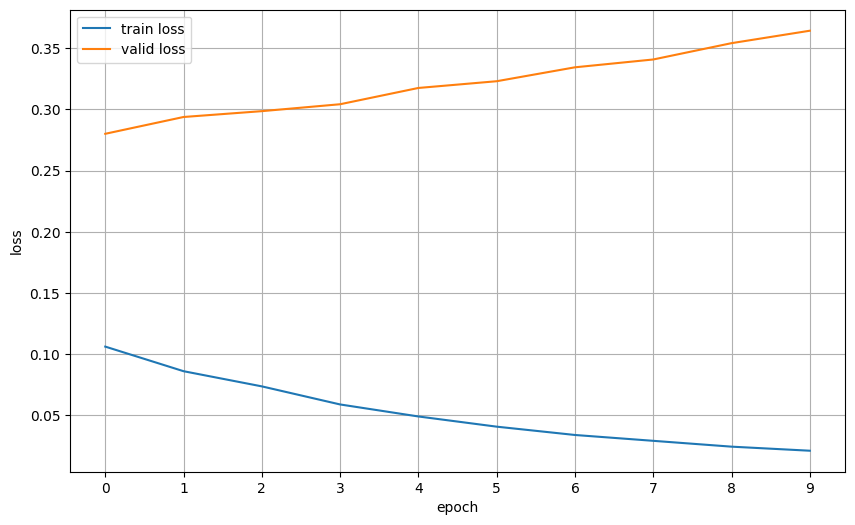

In [99]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

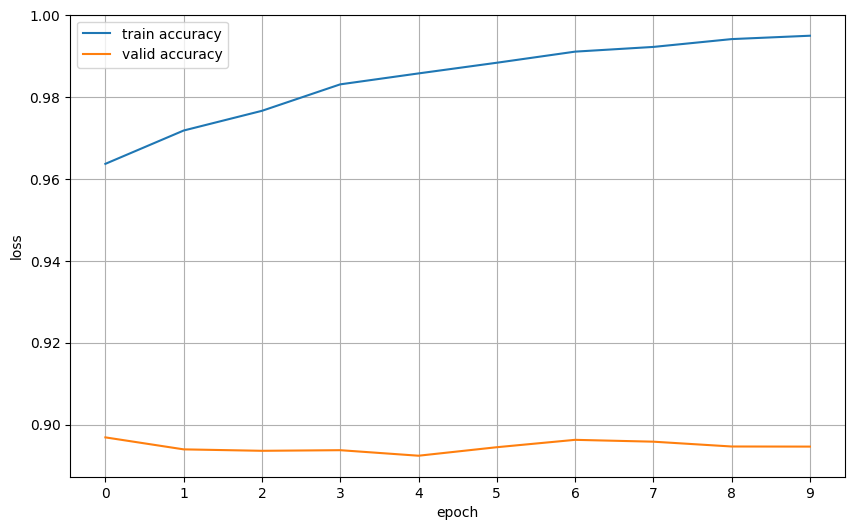

In [100]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [101]:

model.load_state_dict(torch.load("cnn.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 49/49 [00:02<00:00, 19.42it/s]


In [102]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.301, test_acc: 0.880


In [103]:
def predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index):
    tokens = tokenizer(text)
    ids = vocab.lookup_indices(tokens)
    if len(ids) < min_length:
        ids += [pad_index] * (min_length - len(ids))
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [104]:
text = "This film is terrible!"
min_length = max(filter_sizes)

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.9555160403251648)

In [105]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.9718195199966431)

In [106]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(0, 0.6897583603858948)

In [107]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device, min_length, pad_index)

(1, 0.6117761135101318)

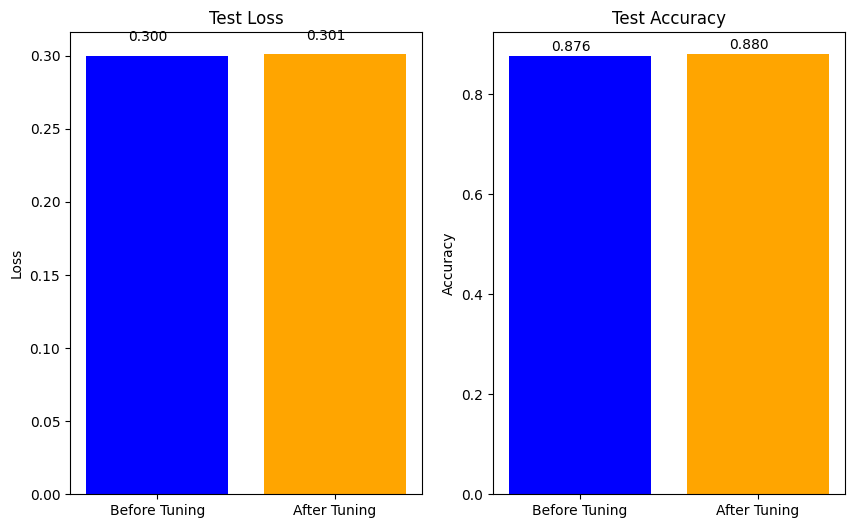

In [109]:
import matplotlib.pyplot as plt

# Test results before hyperparameter tuning
test_loss_before = 0.300
test_acc_before = 0.876

# Test results after hyperparameter tuning
test_loss_after = 0.301
test_acc_after = 0.880

# Plotting
labels = ['Before Tuning', 'After Tuning']
loss_values = [test_loss_before, test_loss_after]
acc_values = [test_acc_before, test_acc_after]

# Plot Test Loss
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
bars = plt.bar(labels, loss_values, color=['blue', 'orange'])
plt.title('Test Loss')
plt.ylabel('Loss')

# Adding values on top of the bars
for bar, value in zip(bars, loss_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.05, bar.get_height() + 0.01, f'{value:.3f}', ha='center', color='black')

# Plot Test Accuracy
plt.subplot(1, 2, 2)
bars = plt.bar(labels, acc_values, color=['blue', 'orange'])
plt.title('Test Accuracy')
plt.ylabel('Accuracy')

# Adding values on top of the bars
for bar, value in zip(bars, acc_values):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.05, bar.get_height() + 0.01, f'{value:.3f}', ha='center', color='black')

plt.show()
